# Boxplot of top five up- and downregulated genes

In [1]:
library(ggpubr)
library(ggsignif)
library(tidyverse)

Loading required package: ggplot2

-- Attaching packages --------------------------------------------------------------------------------------------------------------------- tidyverse 1.3.0 --

v tibble  3.0.4     v dplyr   1.0.2
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.0
v purrr   0.3.4     

-- Conflicts ------------------------------------------------------------------------------------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



## Functions

In [2]:
add_symnum <- function(res){
    symnum.args <- list(cutpoints = c(0, 0.0001, 0.001, 0.01, 0.05,  1),
                        symbols = c("****", "***", "**", "*",  "ns"))
    symnum.args$x <- res$adj.P.Val
    pvalue.signif <- do.call(stats::symnum, symnum.args) %>%
    as.character()
    pvalue.format <- format.pval(res$adj.P.Val, digits = 2)
    res <- res %>%
    dplyr::ungroup() %>%
    mutate(FDR = pvalue.format, p.signif = pvalue.signif)
    return(res)
}

save_ggplots <- function(fn, p, w, h){
    for(ext in c('.pdf', '.png', '.svg')){
        ggsave(paste0(fn, ext), plot=p, width=w, height=h)
    }
}

## Genes

### Differential expressed genes

In [3]:
drd2 = read.delim('../../_m/genes/diffExpr_maleVfemale_full.txt') %>%
    filter(Symbol == 'DRD2') %>% 
    select(gencodeID, ensemblID, Symbol, logFC, t, adj.P.Val) %>%
    add_symnum() %>% mutate_if(is.character, as.factor)
drd2 %>% head(2)

,gencodeID,ensemblID,Symbol,logFC,t,adj.P.Val,FDR,p.signif
,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
1,ENSG00000149295.13,ENSG00000149295,DRD2,0.06191265,1.779219,0.4366278,0.44,ns


### Load residualized expression

In [4]:
res_file = '../../_m/genes/residualized_expression.tsv'
resdf0 = data.table::fread(res_file) %>% 
    filter(V1 %in% drd2$gencodeID) %>% column_to_rownames("V1") %>%
    t %>% data.frame
resdf0 %>% head(2)

Warning message in data.table::fread(res_file):
"Detected 394 column names but the data has 395 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file."


,ENSG00000149295.13
,<dbl>
R12864,-1.696878
R12865,1.456525


### Load pheno data

In [5]:
pheno_file = '/ceph/users/jbenja13/projects/sex_sz_ria/input/phenotypes/_m/phenotypes.csv'
pheno = read.csv(pheno_file) %>% 
    mutate_if(is.character, as.factor) %>% 
    column_to_rownames("RNum") %>% 
    filter(Region=="Caudate") %>%
    select(Sex, Dx, Age, Region, BrNum)
levels(pheno$Sex) <- c("Female", "Male")
head(pheno, 2)

,Sex,Dx,Age,Region,BrNum
,<fct>,<fct>,<dbl>,<fct>,<fct>
R12864,Female,Schizo,42.98,Caudate,Br1303
R12865,Male,Schizo,53.12,Caudate,Br1320


### Merge dataframe

In [6]:
resdf <- inner_join(rownames_to_column(pheno), 
                    rownames_to_column(resdf0), 
                    by="rowname")
dim(resdf)
resdf %>% head(2)

[1] 394   7

,rowname,Sex,Dx,Age,Region,BrNum,ENSG00000149295.13
,<chr>,<fct>,<fct>,<dbl>,<fct>,<fct>,<dbl>
1,R12864,Female,Schizo,42.98,Caudate,Br1303,-1.696878
2,R12865,Male,Schizo,53.12,Caudate,Br1320,1.456525


### Melt data frame

In [7]:
df = resdf %>% select(c('rowname', 'Sex', starts_with('ENSG'))) %>%
    pivot_longer(-c(rowname, Sex), names_to = "gencodeID", values_to = "Res") %>%
    inner_join(drd2, by='gencodeID') %>% 
    mutate_at(vars("Symbol", "gencodeID"), as.factor)

df$Symbol = with(df, reorder(Symbol, adj.P.Val, median))
head(df, 2)

rowname,Sex,gencodeID,Res,ensemblID,Symbol,logFC,t,adj.P.Val,FDR,p.signif
<chr>,<fct>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
R12864,Female,ENSG00000149295.13,-1.696878,ENSG00000149295,DRD2,0.06191265,1.779219,0.4366278,0.44,ns
R12865,Male,ENSG00000149295.13,1.456525,ENSG00000149295,DRD2,0.06191265,1.779219,0.4366278,0.44,ns


### Initial ggplot with ggpubr

Warning message:
"Ignoring unknown aesthetics: xmin, xmax, annotations, y_position"


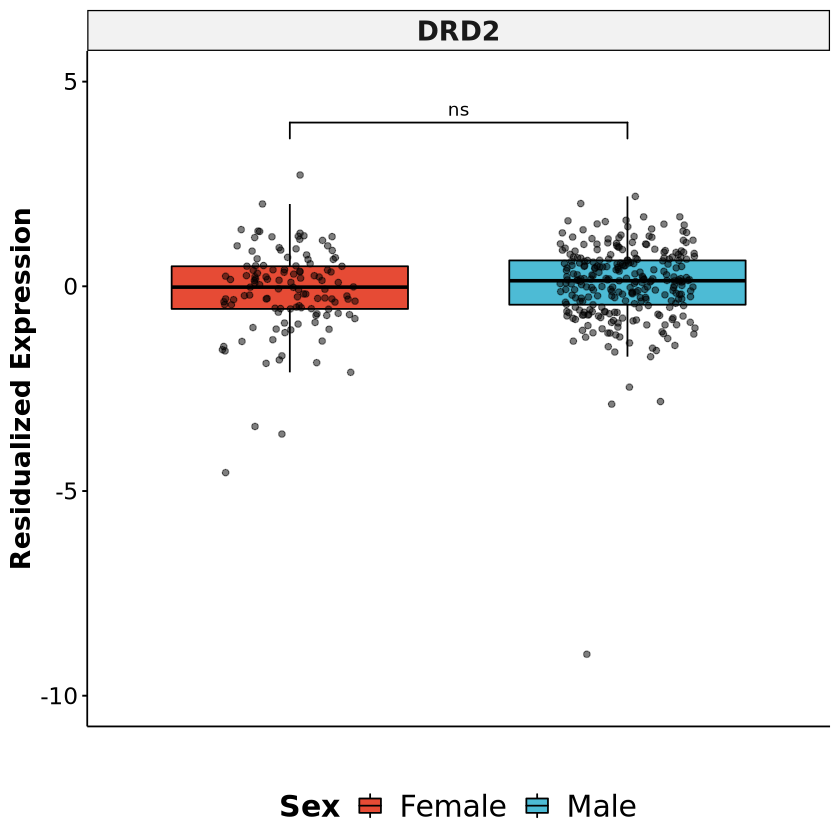

In [9]:
tmp = drd2 %>% mutate(group1='Female', group2='Male', y_pos=4) %>% 
    mutate_if(is.character, as.factor)

bxp_g <- ggboxplot(df, x="Sex", y="Res", facet.by=c("Symbol"), fill="Sex", xlab='', 
                 panel.labs.font=list(face='bold', size = 16), palette="npg", 
                 outlier.shape=NA, ylab='Residualized Expression', add='jitter', 
                 ylim=c(-10, 5), add.params=list(alpha=0.5), legend="bottom",
                 ggtheme=theme_pubr()) +
    geom_signif(data=tmp, 
                aes(xmin=group1, xmax=group2, annotations=p.signif, y_position = y_pos), 
                manual=TRUE) + 
    font("xy.title", size=16, face="bold") + font("xy.text", size=14) +
    font("legend.title", size=18, face="bold") + 
    font("legend.text", size=18) + rremove("x.text") + rremove("x.ticks")
         
bxp_g

## Junction

### Differential expressed genes

In [50]:
drd2 = data.table::fread('../../_m/junctions/diffExpr_maleVfemale_full.txt') %>%
    filter(Symbol == 'DRD2') %>% 
    select(V1, gencodeGeneID, ensemblID, Symbol, logFC, t, adj.P.Val) %>%
    rename("gencodeID"="gencodeGeneID", "Feature"="V1") %>% add_symnum() 
drd2 %>% head(2)

Warning message in data.table::fread("../../_m/junctions/diffExpr_maleVfemale_full.txt"):
"Detected 21 column names but the data has 22 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file."


Feature,gencodeID,ensemblID,Symbol,logFC,t,adj.P.Val,FDR,p.signif
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
chr11:113418137-113424366(-),ENSG00000149295.13,ENSG00000149295,DRD2,0.08748278,1.500196,0.7644762,0.76,ns
chr11:113414462-113415420(-),ENSG00000149295.13,ENSG00000149295,DRD2,0.08620629,1.346190,0.7982172,0.80,ns


### Load residualized expression

In [72]:
res_file = '../../_m/junctions/residualized_expression.tsv'
resdf0 = data.table::fread(res_file) %>% 
    inner_join(drd2, by=c("V1"="Feature")) %>% 
    mutate(ID=paste0("j",1:dim(drd2)[1])) %>% 
    column_to_rownames("ID") %>% select(starts_with("R")) %>%
    t %>% data.frame
resdf0 %>% head(2)
jxn_ann = data.table::fread(res_file) %>% 
    inner_join(drd2, by=c("V1"="Feature")) %>% 
    mutate(ID=paste0("j",1:dim(drd2)[1])) %>% 
    select(!starts_with("R")) 
jxn_ann %>% head(2)

Warning message in data.table::fread(res_file):
"Detected 394 column names but the data has 395 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file."


,j1,j2,j3,j4,j5,j6,j7,j8,j9,j10
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
R12864,-0.7851033,-0.6834095,-0.1130202,-0.8775760,-0.7194466,-0.6075953,-0.4193463,-0.262971773,-0.79178660,0.3874305
R12865,0.3420425,-0.5980531,-1.0812905,0.2162238,0.3266929,0.3583642,-0.2472393,0.004425451,-0.01181165,-3.5792648


Warning message in data.table::fread(res_file):
"Detected 394 column names but the data has 395 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file."


V1,gencodeID,ensemblID,Symbol,logFC,t,adj.P.Val,FDR,p.signif,ID
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
chr11:113410921-113412555(-),ENSG00000149295.13,ENSG00000149295,DRD2,0.07776010,1.203692,0.8286792,0.83,ns,j1
chr11:113412884-113414374(-),ENSG00000149295.13,ENSG00000149295,DRD2,0.08334209,1.293531,0.8108811,0.81,ns,j2


### Load pheno data

In [70]:
pheno_file = '/ceph/users/jbenja13/projects/sex_sz_ria/input/phenotypes/_m/phenotypes.csv'
pheno = read.csv(pheno_file) %>% 
    mutate_if(is.character, as.factor) %>% 
    column_to_rownames("RNum") %>% 
    filter(Region=="Caudate") %>%
    select(Sex, Dx, Age, Region, BrNum)
levels(pheno$Sex) <- c("Female", "Male")
head(pheno, 2)

,Sex,Dx,Age,Region,BrNum
,<fct>,<fct>,<dbl>,<fct>,<fct>
R12864,Female,Schizo,42.98,Caudate,Br1303
R12865,Male,Schizo,53.12,Caudate,Br1320


### Merge dataframe

In [71]:
resdf <- inner_join(rownames_to_column(pheno), 
                    rownames_to_column(resdf0), 
                    by="rowname")
dim(resdf)
resdf %>% head(2)

[1] 394  16

,rowname,Sex,Dx,Age,Region,BrNum,j1,j2,j3,j4,j5,j6,j7,j8,j9,j10
,<chr>,<fct>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,R12864,Female,Schizo,42.98,Caudate,Br1303,-0.7851033,-0.6834095,-0.1130202,-0.8775760,-0.7194466,-0.6075953,-0.4193463,-0.262971773,-0.79178660,0.3874305
2,R12865,Male,Schizo,53.12,Caudate,Br1320,0.3420425,-0.5980531,-1.0812905,0.2162238,0.3266929,0.3583642,-0.2472393,0.004425451,-0.01181165,-3.5792648


### Melt data frame

In [75]:
df = resdf %>% select(c('rowname', 'Sex', starts_with('j'))) %>%
    pivot_longer(-c(rowname, Sex), names_to = "ID", values_to = "Res") %>%
    inner_join(jxn_ann, by="ID") %>% mutate(New_ID=paste(Symbol, V1, sep='\n')) %>%
    mutate_at(vars("Symbol", "New_ID"), as.factor)
df$New_ID = with(df, reorder(New_ID, adj.P.Val, median))
df %>% head(2)

rowname,Sex,ID,Res,V1,gencodeID,ensemblID,Symbol,logFC,t,adj.P.Val,FDR,p.signif,New_ID
<chr>,<fct>,<chr>,<dbl>,<chr>,<chr>,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>
R12864,Female,j1,-0.7851033,chr11:113410921-113412555(-),ENSG00000149295.13,ENSG00000149295,DRD2,0.07776010,1.203692,0.8286792,0.83,ns,DRD2 chr11:113410921-113412555(-)
R12864,Female,j2,-0.6834095,chr11:113412884-113414374(-),ENSG00000149295.13,ENSG00000149295,DRD2,0.08334209,1.293531,0.8108811,0.81,ns,DRD2 chr11:113412884-113414374(-)


### Initial ggplot with ggpubr

Warning message:
"Ignoring unknown aesthetics: xmin, xmax, annotations, y_position"


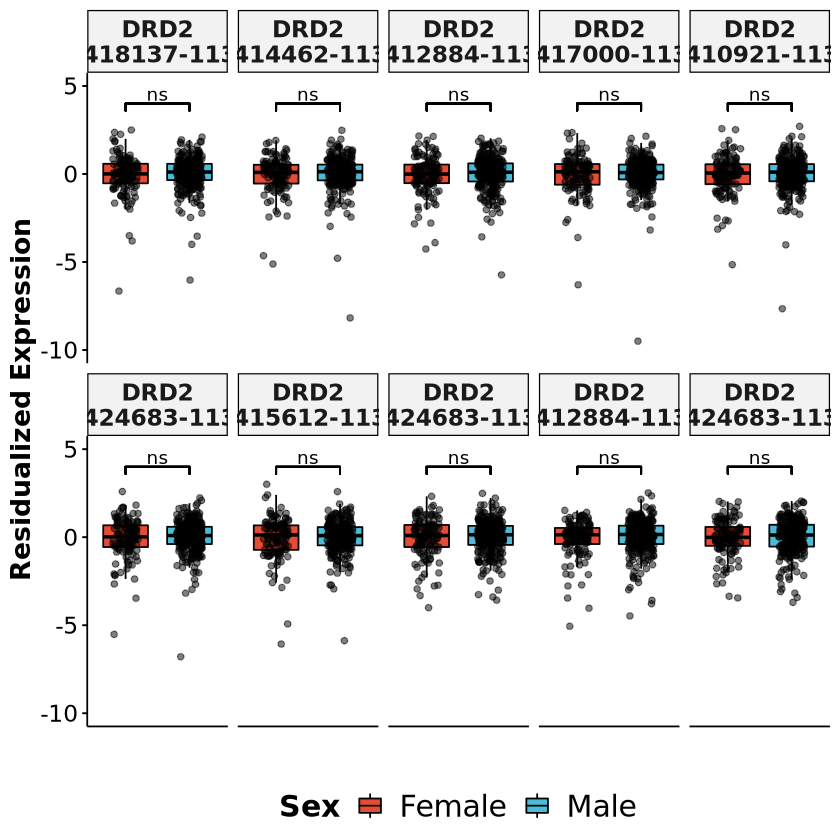

In [88]:
tmp = drd2 %>% mutate(group1='Female', group2='Male', y_pos=4) %>% 
    mutate_if(is.character, as.factor)

bxp_j <- ggboxplot(df, x="Sex", y="Res", facet.by=c("New_ID"), fill="Sex", xlab='', 
                 panel.labs.font=list(face='bold', size = 14), palette="npg", 
                 outlier.shape=NA, ylab='Residualized Expression', add='jitter', 
                 ylim=c(-10, 5), add.params=list(alpha=0.5), legend="bottom",
                 ggtheme=theme_pubr(), ncol=5) +
    geom_signif(data=tmp, 
                aes(xmin=group1, xmax=group2, annotations=p.signif, y_position = y_pos), 
                manual=TRUE) + 
    font("xy.title", size=20, face="bold") + font("xy.text", size=14) +
    font("legend.title", size=18, face="bold") + 
    font("legend.text", size=18) + rremove("x.text") + rremove("x.ticks")
         
bxp_j

### Annotate figure

In [91]:
save_ggplots('drd2_gene', bxp_g, 6, 6)
save_ggplots('drd2_junctions', bxp_j, 16, 10)

## Session Info

In [ ]:
Sys.time()
proc.time()
options(width = 120)
sessioninfo::session_info()